In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re #For using Regex
!pip install langdetect
from langdetect import detect #to detect language
!pip install transformers
import transformers
from transformers import pipeline
import warnings
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from scipy.special import softmax



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


UnboundLocalError: local variable 'child' referenced before assignment

## Loading Excel to Pandas

In [ ]:
xlsx_file = "/kaggle/input/Coding_Files_Prepared_for_NLP.xlsx"
xlsx_data = pd.read_excel(xlsx_file, sheet_name=None, header=0)
combined_df = xlsx_data['EverythingCombined']
m3_df = xlsx_data['M3_Quotation']
oporajita_df = xlsx_data['Oporajita_Quotation']
design_df = xlsx_data['Design_Quotation']


In [ ]:
# columns = ['Participant', 'Description']
# trimmed_combined_df = combined_df[columns]
# trimmed_m3_df = m3_df[columns]
# trimmed_oporajita_df = oporajita_df[columns]
# trimmed_design_df = design_df[columns]
# print(trimmed_combined_df)
# print(trimmed_m3_df)
# print(trimmed_oporajita_df)
# print(trimmed_design_df)

## Cleaning Dataset

In [ ]:
def clean_text(text):
    regex = r'-\s*P\d+$'
    cleaned_text = re.sub(regex, '', text)
    return cleaned_text

cleaned_combined_df = combined_df.copy()
cleaned_combined_df['Description'] = cleaned_combined_df['Description'].apply(clean_text)

cleaned_m3_df = m3_df.copy()
cleaned_m3_df['Description'] = cleaned_m3_df['Description'].apply(clean_text)

cleaned_oporajita_df = oporajita_df.copy()
cleaned_oporajita_df['Description'] = cleaned_oporajita_df['Description'].apply(clean_text)

cleaned_design_df = design_df.copy()
cleaned_design_df['Description'] = cleaned_design_df['Description'].apply(clean_text)

# print(cleaned_combined_df)
# print(cleaned_m3_df)
# print(cleaned_oporajita_df)
# print(cleaned_design_df)

In [ ]:
output_file = 'cleaned_dataset.xlsx'
# Create an Excel writer object
with pd.ExcelWriter(output_file) as writer:
    # Write each DataFrame to a separate sheet in the Excel file
    cleaned_combined_df.to_excel(writer, sheet_name='Combined', index=False)
    cleaned_m3_df.to_excel(writer, sheet_name='M3', index=False)
    cleaned_oporajita_df.to_excel(writer, sheet_name='Oporajita', index=False)
    cleaned_design_df.to_excel(writer, sheet_name='Design', index=False)

# Notify user about the successful export
print(f"DataFrames exported to {output_file} successfully!")

## Converting Dataset To English


In [ ]:
bn_to_en = pipeline("translation", model="csebuetnlp/banglat5_nmt_bn_en")

def convert_to_en(text):
    if detect(text) == 'bn':
        translation_result = bn_to_en(text)
        return translation_result[0]['translation_text']
    else:
        return text

translated_combined_df = cleaned_combined_df.copy()
translated_combined_df['Description'] = translated_combined_df['Description'].apply(convert_to_en)

translated_m3_df = cleaned_m3_df.copy()
translated_m3_df['Description'] = translated_m3_df['Description'].apply(convert_to_en)

translated_oporajita_df = cleaned_oporajita_df.copy()
translated_oporajita_df['Description'] = translated_oporajita_df['Description'].apply(convert_to_en)

translated_design_df = cleaned_design_df.copy()
translated_design_df['Description'] = translated_design_df['Description'].apply(convert_to_en)

# print(translated_combined_df)
# print(translated_m3_df)
# print(translated_oporajita_df)
# print(translated_design_df)

In [ ]:
output_file = 'translated_dataset.xlsx'
# Create an Excel writer object
with pd.ExcelWriter(output_file) as writer:
    # Write each DataFrame to a separate sheet in the Excel file
    translated_combined_df.to_excel(writer, sheet_name='Combined', index=False)
    translated_m3_df.to_excel(writer, sheet_name='M3', index=False)
    translated_oporajita_df.to_excel(writer, sheet_name='Oporajita', index=False)
    translated_design_df.to_excel(writer, sheet_name='Design', index=False)

# Notify user about the successful export
print(f"DataFrames exported to {output_file} successfully!")

## Emotion Analysis

In [ ]:
emotion_analysis = pipeline("text-classification", model="SamLowe/roberta-base-go_emotions", top_k=3)
def analyze_emotion(text):
    result = emotion_analysis(text)
    label_1 = result[0][0]['label']
    score_1 = result[0][0]['score']
    label_2 = result[0][1]['label']
    score_2 = result[0][1]['score']
    label_3 = result[0][2]['label']
    score_3 = result[0][2]['score']
    return label_1, label_2, label_3, score_1, score_2, score_3


def apply_emotion_analysis(df):
    emotions = df['Description'].apply(lambda x: analyze_emotion(x))
    df['Emotion_Label_1'] = emotions.apply(lambda x: x[0])
    df['Emotion_Label_2'] = emotions.apply(lambda x: x[1])
    df['Emotion_Label_3'] = emotions.apply(lambda x: x[2])
    df['Emotion_Score_1'] = emotions.apply(lambda x: x[3])
    df['Emotion_Score_2'] = emotions.apply(lambda x: x[4])
    df['Emotion_Score_3'] = emotions.apply(lambda x: x[5])
    return df

# Apply emotion analysis to each DataFrame
em_combined_df = apply_emotion_analysis(translated_combined_df)
em_m3_df = apply_emotion_analysis(translated_m3_df)
em_oporajita_df = apply_emotion_analysis(translated_oporajita_df)
em_design_df = apply_emotion_analysis(translated_design_df)


# print(em_translated_combined_df)
# print(em_translated_m3_df)
# print(em_translated_oporajita_df)
# print(em_translated_design_df)

In [51]:
output_file = 'calculated_emotion_dataset.xlsx'
# Create an Excel writer object
with pd.ExcelWriter(output_file) as writer:
    # Write each DataFrame to a separate sheet in the Excel file
    em_combined_df.to_excel(writer, sheet_name='Combined', index=False)
    em_m3_df.to_excel(writer, sheet_name='M3', index=False)
    em_oporajita_df.to_excel(writer, sheet_name='Oporajita', index=False)
    em_design_df.to_excel(writer, sheet_name='Design', index=False)

# Notify user about the successful export
print(f"DataFrames exported to {output_file} successfully!")

DataFrames exported to calculated_emotion_dataset.xlsx successfully!


In [35]:
def analyze_sentiment(text):
    
    # Suppress specific warning
    warnings.filterwarnings("ignore", message="Some weights of the model checkpoint .*")
    
    MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    config = AutoConfig.from_pretrained(MODEL)

    # PT
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)

    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    # Create a dictionary to store sentiment labels and their scores
    results = {}
    for i in range(scores.shape[0]):
        l = config.id2label[i]
        s = np.round(float(scores[i]), 4)
        results[l] = s

    return results['positive'], results['neutral'], results['negative']



def apply_sentiment_analysis(df):
    sentiment = df['Description'].apply(lambda x: analyze_sentiment(x))
    df['Sentiment_Positive'] = sentiment.apply(lambda x: x[0])
    df['Sentiment_Neutral'] = sentiment.apply(lambda x: x[1])
    df['Sentiment_Negative'] = sentiment.apply(lambda x: x[2])

    return df

# Apply emotion analysis to each DataFrame
sn_combined_df = apply_sentiment_analysis(translated_combined_df)
sn_m3_df = apply_sentiment_analysis(translated_m3_df)
sn_oporajita_df = apply_sentiment_analysis(translated_oporajita_df)
sn_design_df = apply_sentiment_analysis(translated_design_df)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassifi

In [50]:
output_file = 'calculated_sentiment_dataset.xlsx'
# Create an Excel writer object
with pd.ExcelWriter(output_file) as writer:
    # Write each DataFrame to a separate sheet in the Excel file
    sn_combined_df.to_excel(writer, sheet_name='Combined', index=False)
    sn_m3_df.to_excel(writer, sheet_name='M3', index=False)
    sn_oporajita_df.to_excel(writer, sheet_name='Oporajita', index=False)
    sn_design_df.to_excel(writer, sheet_name='Design', index=False)

# Notify user about the successful export
print(f"DataFrames exported to {output_file} successfully!")

DataFrames exported to calculated_sentiment_dataset.xlsx successfully!


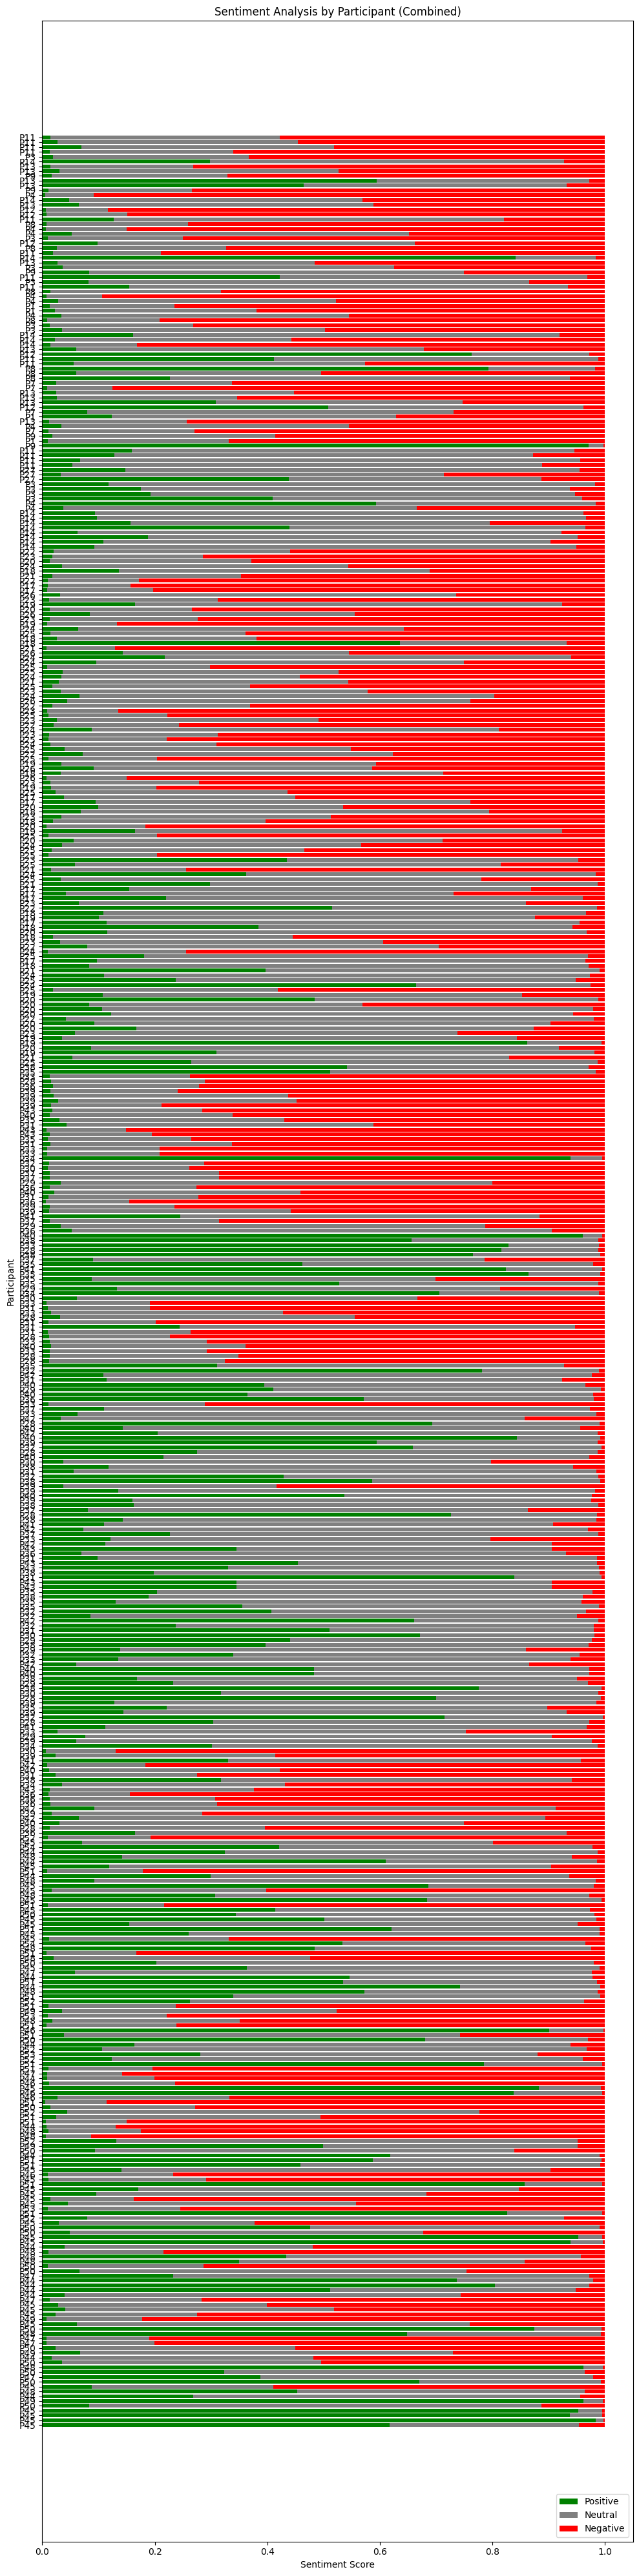

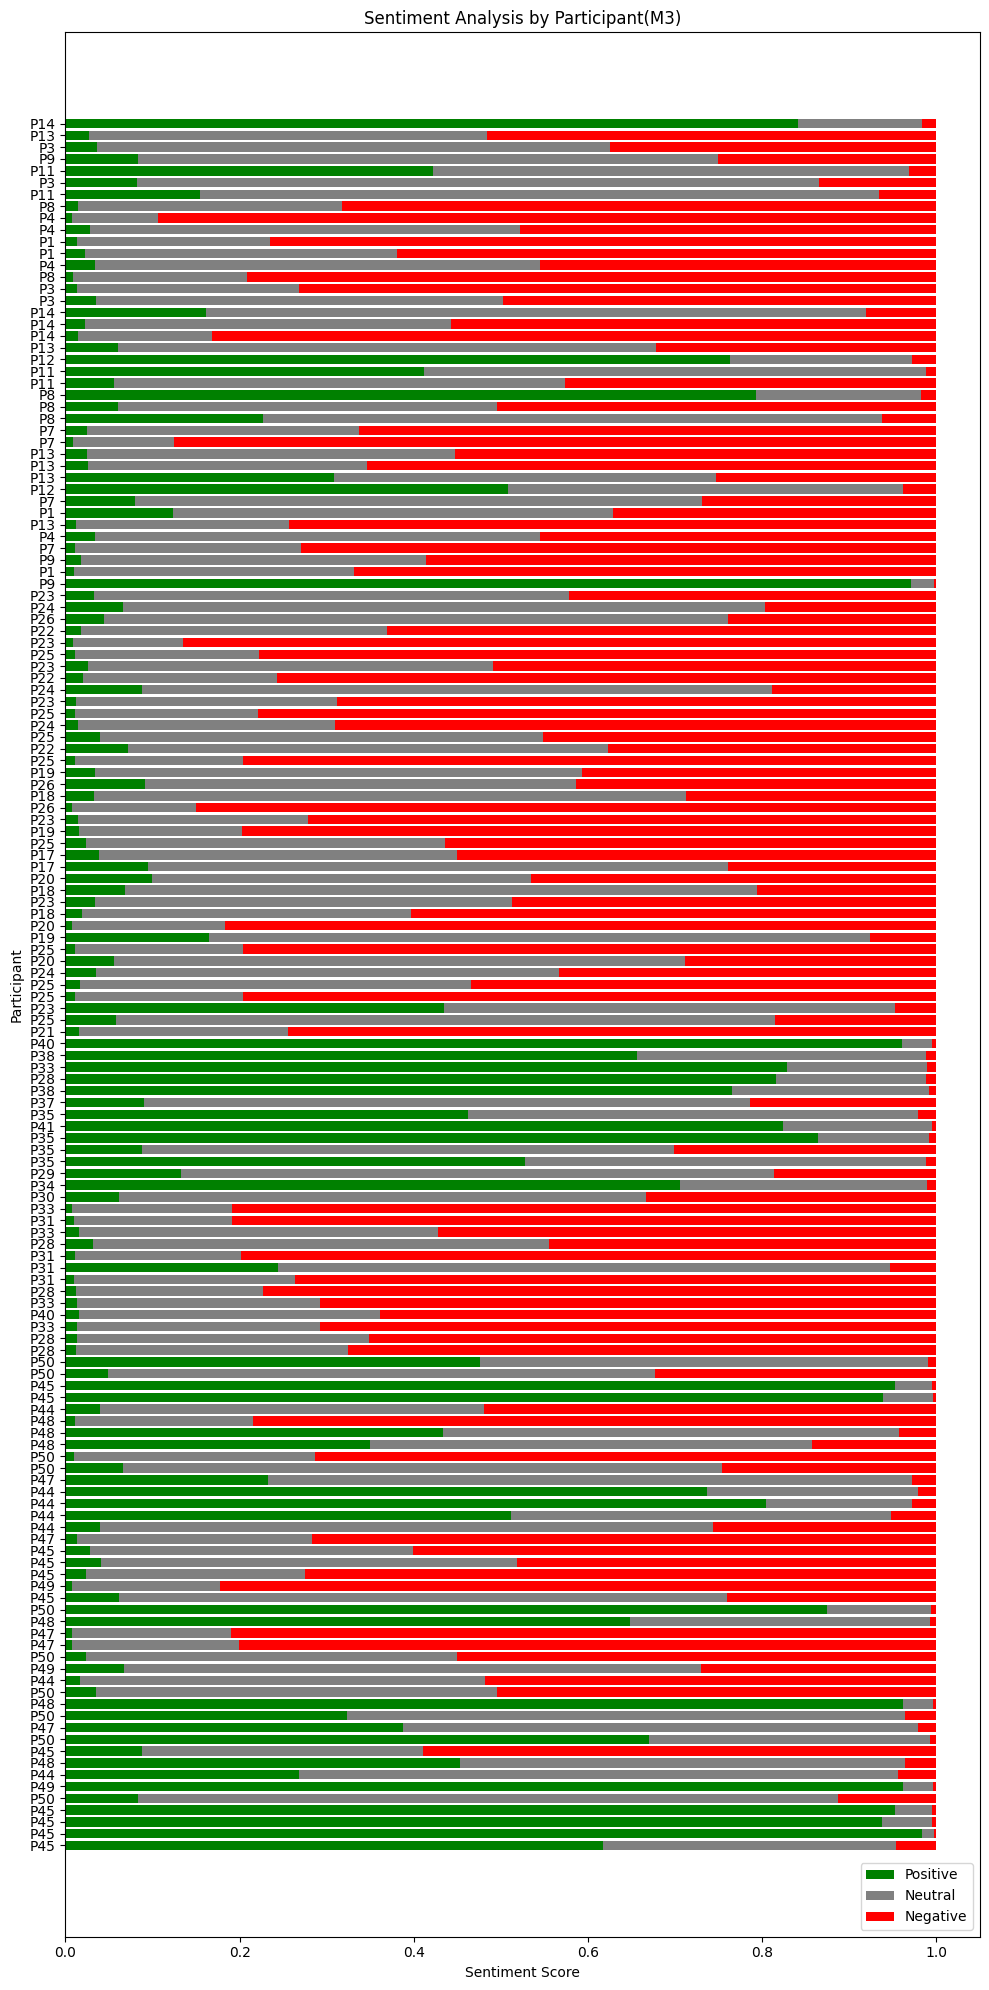

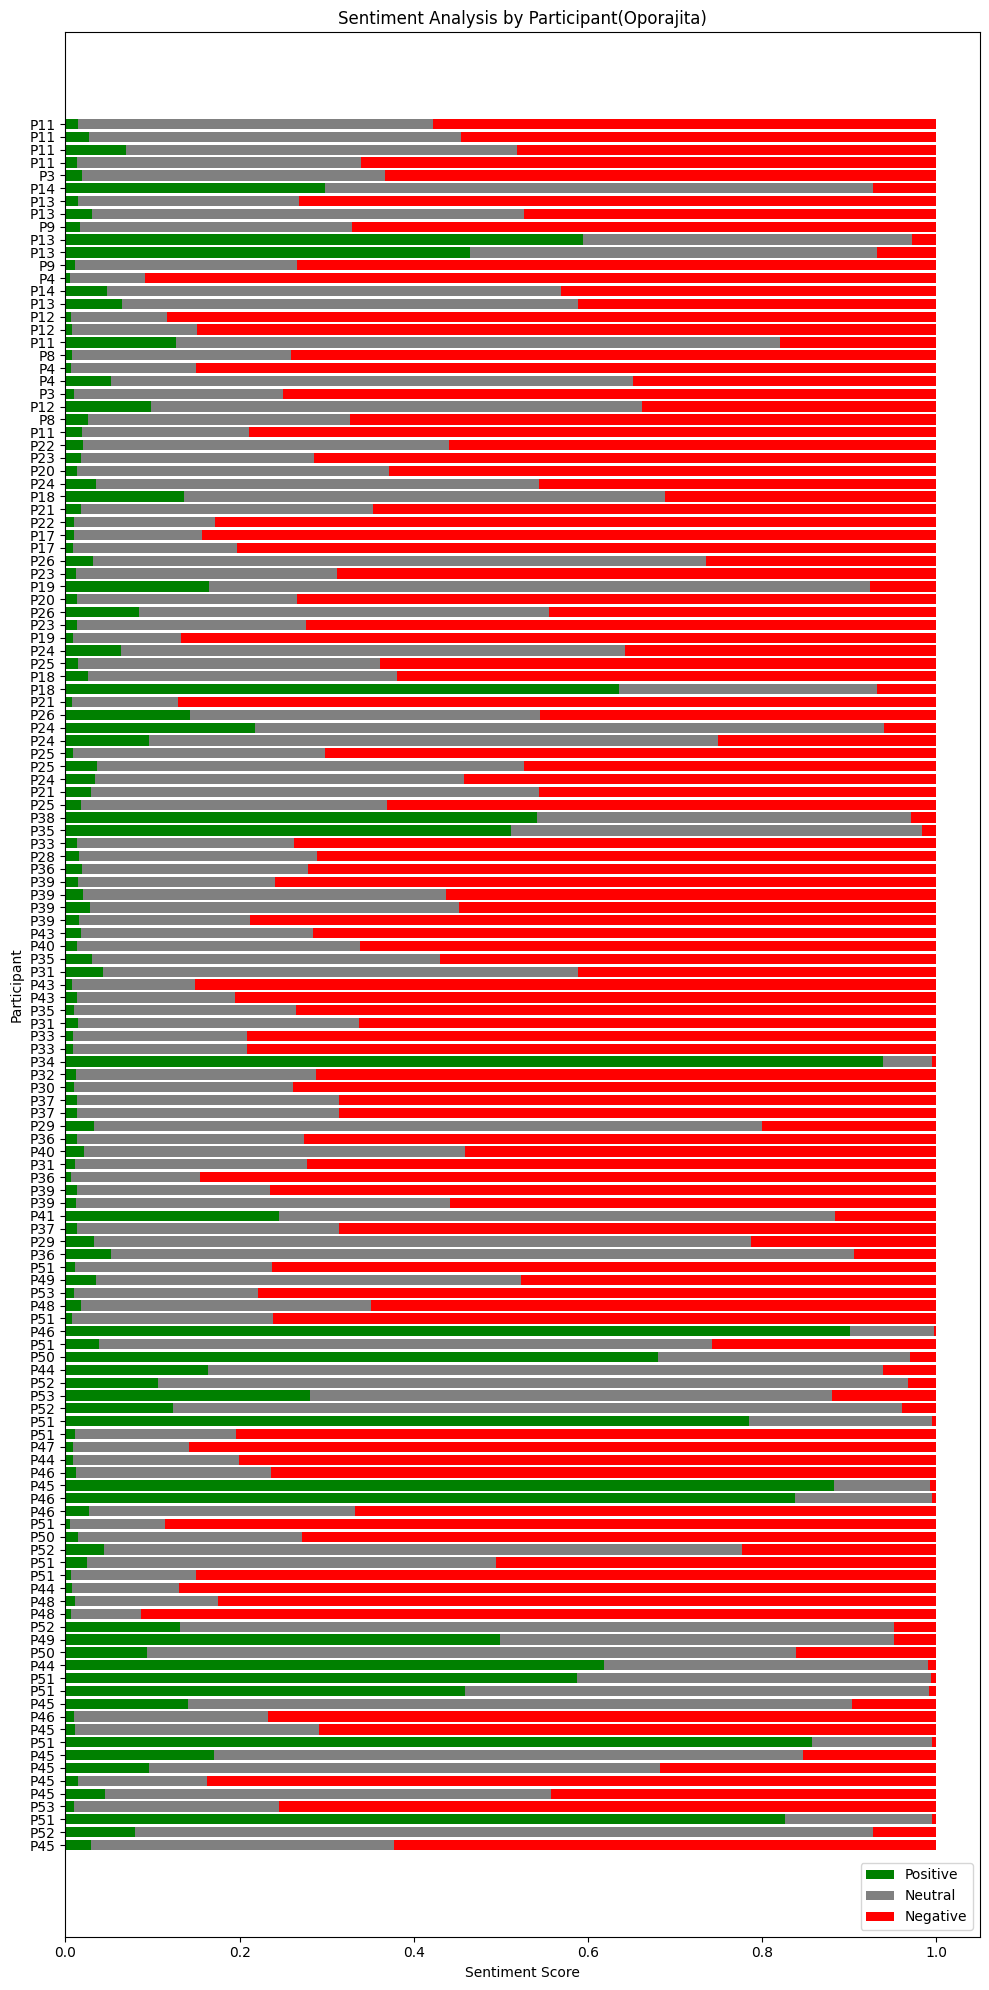

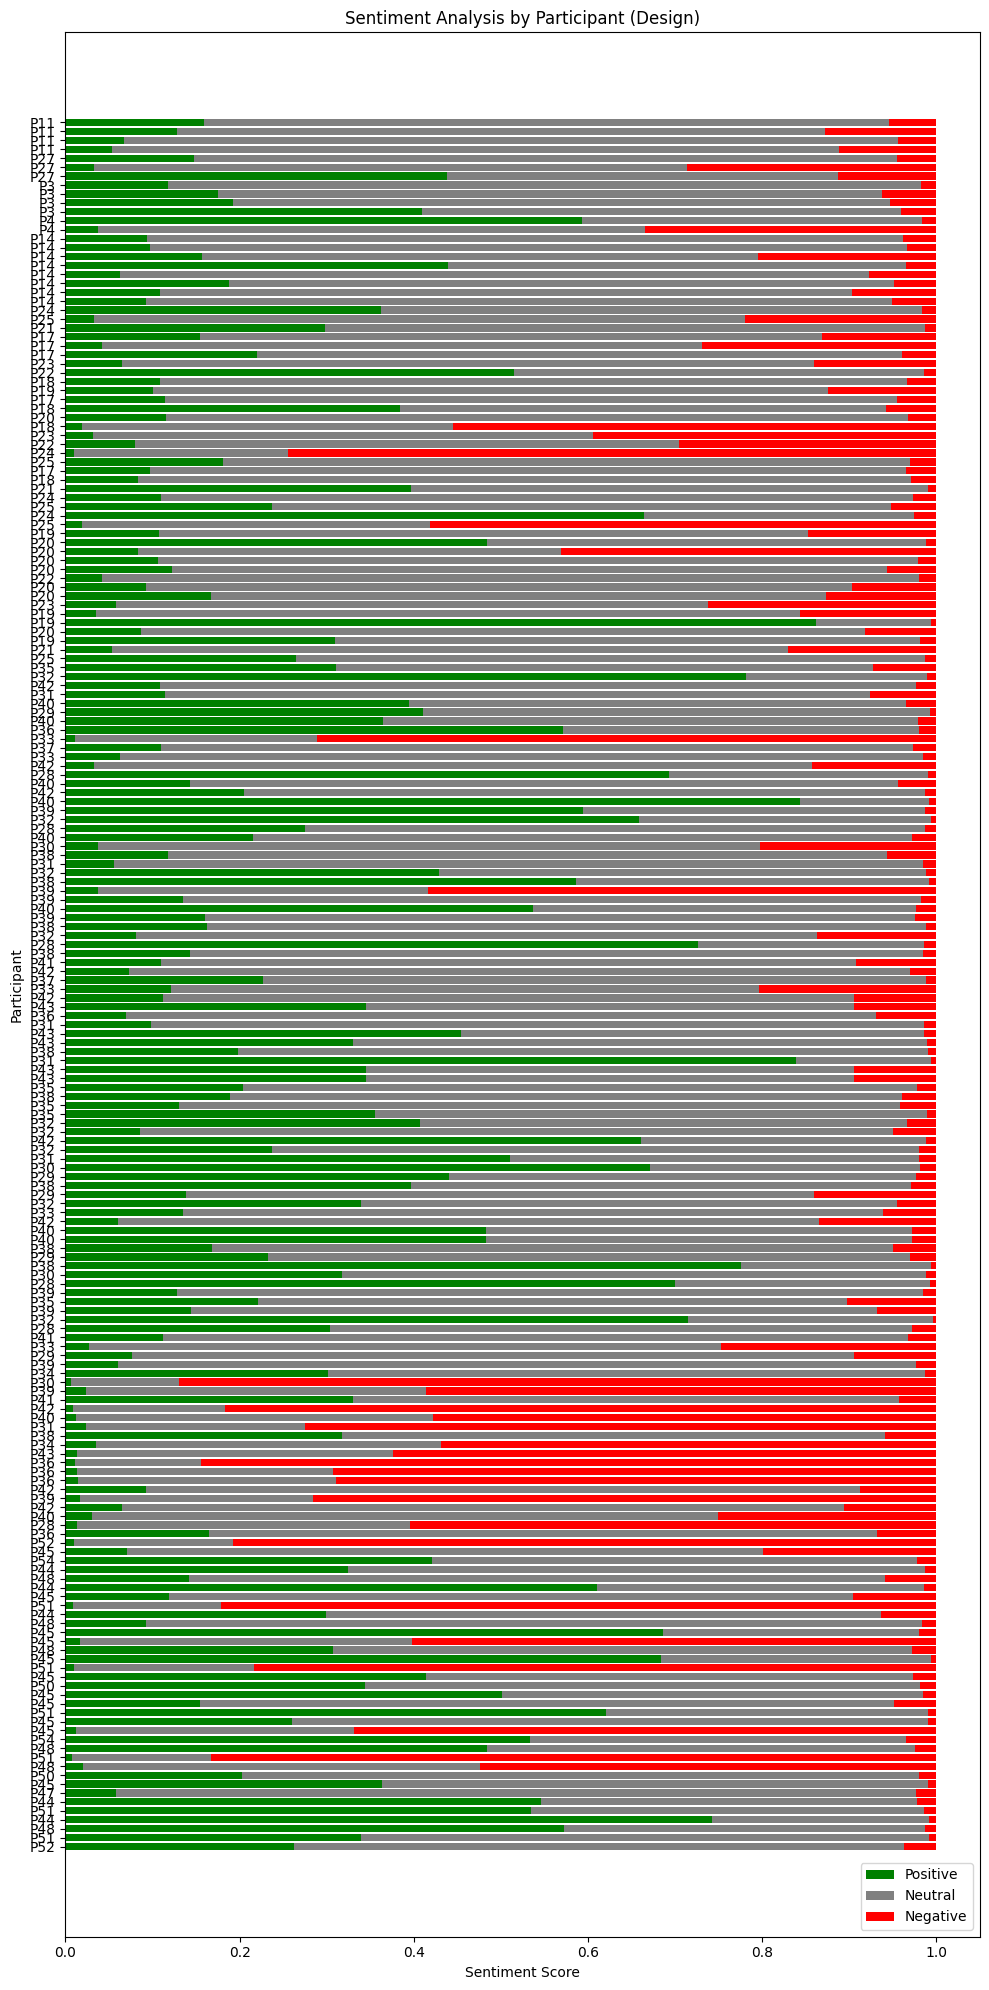

In [77]:
df = sn_combined_df
import matplotlib.pyplot as plt

import numpy as np

# Stacked bar chart
plt.figure(figsize=(8, 50))

# Create an array of y-coordinates for each participant
y = np.arange(len(df))

# Iterate through each row in the DataFrame
for i, row in df.iterrows():
    participant = row['Participant']
    plt.barh(y[i], row['Sentiment_Positive'], color='green', label='Positive' if i == 0 else None)
    plt.barh(y[i], row['Sentiment_Neutral'], left=row['Sentiment_Positive'], color='grey', label='Neutral' if i == 0 else None)
    plt.barh(y[i], row['Sentiment_Negative'], left=row['Sentiment_Positive'] + row['Sentiment_Neutral'], color='red', label='Negative' if i == 0 else None)

plt.xlabel('Sentiment Score')
plt.ylabel('Participant')
plt.title('Sentiment Analysis by Participant (Combined)')
plt.legend(loc='lower right')
plt.yticks(y, df['Participant'])  # Set y-ticks to participant names
plt.tight_layout()
plt.show()

df = sn_m3_df
# Stacked bar chart
plt.figure(figsize=(8, 20))

# Create an array of y-coordinates for each participant
y = np.arange(len(df))

# Iterate through each row in the DataFrame
for i, row in df.iterrows():
    participant = row['Participant']
    plt.barh(y[i], row['Sentiment_Positive'], color='green', label='Positive' if i == 0 else None)
    plt.barh(y[i], row['Sentiment_Neutral'], left=row['Sentiment_Positive'], color='grey', label='Neutral' if i == 0 else None)
    plt.barh(y[i], row['Sentiment_Negative'], left=row['Sentiment_Positive'] + row['Sentiment_Neutral'], color='red', label='Negative' if i == 0 else None)

plt.xlabel('Sentiment Score')
plt.ylabel('Participant')
plt.title('Sentiment Analysis by Participant(M3)')
plt.legend(loc='lower right')
plt.yticks(y, df['Participant'])  # Set y-ticks to participant names
plt.tight_layout()
plt.show()

df = sn_oporajita_df


# Stacked bar chart
plt.figure(figsize=(8, 20))

# Create an array of y-coordinates for each participant
y = np.arange(len(df))

# Iterate through each row in the DataFrame
for i, row in df.iterrows():
    participant = row['Participant']
    plt.barh(y[i], row['Sentiment_Positive'], color='green', label='Positive' if i == 0 else None)
    plt.barh(y[i], row['Sentiment_Neutral'], left=row['Sentiment_Positive'], color='grey', label='Neutral' if i == 0 else None)
    plt.barh(y[i], row['Sentiment_Negative'], left=row['Sentiment_Positive'] + row['Sentiment_Neutral'], color='red', label='Negative' if i == 0 else None)

plt.xlabel('Sentiment Score')
plt.ylabel('Participant')
plt.title('Sentiment Analysis by Participant(Oporajita)')
plt.legend(loc='lower right')
plt.yticks(y, df['Participant'])  # Set y-ticks to participant names
plt.tight_layout()
plt.show()

df = sn_design_df

# Stacked bar chart
plt.figure(figsize=(8, 20))

# Create an array of y-coordinates for each participant
y = np.arange(len(df))

# Iterate through each row in the DataFrame
for i, row in df.iterrows():
    participant = row['Participant']
    plt.barh(y[i], row['Sentiment_Positive'], color='green', label='Positive' if i == 0 else None)
    plt.barh(y[i], row['Sentiment_Neutral'], left=row['Sentiment_Positive'], color='grey', label='Neutral' if i == 0 else None)
    plt.barh(y[i], row['Sentiment_Negative'], left=row['Sentiment_Positive'] + row['Sentiment_Neutral'], color='red', label='Negative' if i == 0 else None)

plt.xlabel('Sentiment Score')
plt.ylabel('Participant')
plt.title('Sentiment Analysis by Participant (Design)')
plt.legend(loc='lower right')
plt.yticks(y, df['Participant'])  # Set y-ticks to participant names
plt.tight_layout()
plt.show()